In [1]:
import gmsh
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from matplotlib.tri import Triangulation
from matplotlib import cm, patches, collections

In [2]:
experiment='run_330d_iabp'

In [3]:
mesh_file='/bettik/alberta/small-arctic-10km-iabp/experiments/run_330d_iabp/par32small_arctic_10km.msh'

In [4]:
gmsh.initialize()
file = gmsh.open(mesh_file)

Info    : Reading '/bettik/alberta/small-arctic-10km-iabp/experiments/run_330d_iabp/par32small_arctic_10km.msh'...
Info    : 66212 nodes
Info    : 130689 elements
Info    : Converting old partitioning...                                   
Info    : Creating partition topology...
Info    :  - Creating partition curves
Info    :  - Creating partition points
Info    : Done creating partition topology
Info    : Done reading '/bettik/alberta/small-arctic-10km-iabp/experiments/run_330d_iabp/par32small_arctic_10km.msh'


In [5]:
# Number of partitions (i.e. as many partitions as processors on which the simulation has run)
NP =  gmsh.model.getNumberOfPartitions()
print(NP)

# Get all Entities from gmsh file
entities = gmsh.model.getEntities()

32


In [6]:
def GetPartitionsFromEntities(entities,NP):
    """ Gets mesh triangles and nodes coordinates from reading the entities of a gmsh file.
    
    Reads all entities from the gmsh model and look for "Partition surfaces". Loops over the partitions 
    and gets for each partition, all the nodes includes in the partitions (reads their x,y coordinates) 
    and all the mesh elements corresponding to this partitions (i.e. the triangles).
    
    Parameters
    ----------
    entities : Previously read from gmsh file 
        with 'entities = gmsh.model.getEntities()'

    NP : int
        Number of partitions (read from gmsh file with
        'NP=gmsh.model.getNumberOfPartitions()'
        
    Returns
    -------
    3 array_like of size NPx5000
        bigelemtags,bignodes_x,bignodes_y
        containing , for each of the NP partition, the tag of each elements, the x and y coordinates of each node.
    """
    bignodes_x = np.zeros((NP,5000))
    bignodes_y = np.zeros((NP,5000))
    bigelemtags = np.zeros((NP,5000))
    for ipart in range(0,NP):
        icount=-1
        for e in entities:
            if (gmsh.model.getType(e[0], e[1])=="Partition surface"):
                partitions = gmsh.model.getPartitions(e[0], e[1])
                if len(partitions):
                    if ipart in partitions:
                        # get the mesh nodes for each elementary entity
                        nodeTags, nodeCoords, nodeParams = gmsh.model.mesh.getNodes(e[0], e[1])
                        # Get the mesh elements for the entity (dim, tag):
                        elemTypes, elemTags, elemNodeTags = gmsh.model.mesh.getElements(e[0], e[1])
                        # save x,y coordinates of all nodes in the given partition (ipart)
                        bignodes_x[ipart,:len(nodeCoords[0::3])] = nodeCoords[0::3]
                        bignodes_y[ipart,:len(nodeCoords[1::3])] = nodeCoords[1::3]
                        # save the elements tag in the given partition
                        bigelemtags[ipart,:len(elemTags[0])] = elemTags[0]
    return bigelemtags,bignodes_x,bignodes_y


def preparecollection4plt(patchlist,c):
    """ Prepare to plot the patch for each partiton
    
    
    Parameters
    ----------
    patchlist : computed from makecollectionpart

    c : hex color
        color to plot the partition with
        
    Returns
    -------
    pc the patch collection to plot
        

    """
    pc = collections.PatchCollection(patchlist, cmap='binary', alpha=1)
    pc.set_array(np.zeros(1))
    pc.set_edgecolor(c)
    return pc

def makecollectionpart(bigelemtags,ipart,sfac):
    """ Collect all triangles to plot for a given partiton
    
    
    Parameters
    ----------
    bigelemtags : array of all tags of elements corresponding to each of the NP partitons

    ipart : int 
        partition index
    
    sfac  : float
        
        scale factor to convert the coordinates with (for example from m to km)
    Returns
    -------
    patch_list corresponding to the given partition
        
    """

    #Set up the triangles
    patch_list  = []
    rgba_list = []
    nodes1_x = []
    nodes1_y = []
    nodes2_x = []
    nodes2_y = []
    nodes3_x = []
    nodes3_y = []
    part = []
    tag = []

    for t in np.arange(len(bigelemtags[ipart,:])):
        #print(t)
        tag1 = int(bigelemtags[ipart,t])
        if tag1>0:
            eltyp,nodetags,dim,tag2 = gmsh.model.mesh.get_element(tag1)
            part.append(tag2)

            tag.append(t)

            n1=gmsh.model.mesh.get_node(nodetags[0])
            n1_coord=n1[0]
            n1_x=n1_coord[0]*sfac
            n1_y=n1_coord[1]*sfac
            nodes1_x.append(n1_x)
            nodes1_y.append(n1_y)

            n2=gmsh.model.mesh.get_node(nodetags[1])
            n2_coord=n2[0]
            n2_x=n2_coord[0]*sfac
            n2_y=n2_coord[1]*sfac
            nodes2_x.append(n2_x)
            nodes2_y.append(n2_y)

            n3=gmsh.model.mesh.get_node(nodetags[2])
            n3_coord=n3[0]
            n3_x=n3_coord[0]*sfac
            n3_y=n3_coord[1]*sfac
            nodes3_x.append(n3_x)
            nodes3_y.append(n3_y)

            ccl   = []
            ccl.append((n1_x,n1_y))
            ccl.append((n2_x,n2_y))
            ccl.append((n3_x,n3_y))
            ccl.append(ccl[0])
            
            patch_list.append(patches.Polygon(ccl,True,linewidth=0))
    return patch_list        


In [7]:
bigelemtags,bignodes_x,bignodes_y = GetPartitionsFromEntities(entities,NP)               

In [8]:
# scale factor so that x and y are in km instead of m
sfac=1e-3

# initialize a list that will collect the NP lists corresponding to each of the NP partitions
allpatchlists=[]

# loop on the partitions
for ipart in range(0,NP):
    allpatchlists.append(makecollectionpart(bigelemtags,ipart,sfac))


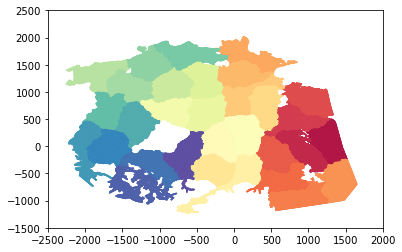

In [9]:
# create a color_list of NP different colors
cmap = cm.get_cmap('Spectral', NP)
color_list = [matplotlib.colors.rgb2hex(cmap(i)[:3]) for i in range(cmap.N)]

# create figure
ax = plt.figure().add_subplot(111)
fig = ax.figure

ax.set_xlim(-2500,2000)
ax.set_ylim(-1500,2500)

# loop on the NP partitions and plot the corresponding collection of patches with a given color
for ip in range(0,NP):
    ax.add_collection(preparecollection4plt(allpatchlists[ip],color_list[ip]))



In [10]:
!ls /bettik/alberta/small-arctic-10km-iabp/experiments/run_330d_iabp/drifters

/bin/bash: warning: setlocale: LC_ALL: cannot change locale (en_US.utf8)
drifter_11247.npz  drifter_24224.npz  drifter_5311.npz	 drifter_66301.npz
drifter_11248.npz  drifter_25752.npz  drifter_5312.npz	 drifter_66302.npz
drifter_11249.npz  drifter_25776.npz  drifter_5314.npz	 drifter_66303.npz
drifter_1222.npz   drifter_25820.npz  drifter_5317.npz	 drifter_66304.npz
drifter_1907.npz   drifter_25887.npz  drifter_5318.npz	 drifter_66305.npz
drifter_1908.npz   drifter_26699.npz  drifter_53537.npz  drifter_66739.npz
drifter_19579.npz  drifter_26916.npz  drifter_53540.npz  drifter_66740.npz
drifter_22068.npz  drifter_26917.npz  drifter_53541.npz  drifter_7413.npz
drifter_22082.npz  drifter_26919.npz  drifter_64877.npz  drifter_7440.npz
drifter_22086.npz  drifter_3691.npz   drifter_64878.npz  drifter_7948.npz
drifter_23678.npz  drifter_3692.npz   drifter_64879.npz  drifter_7949.npz
drifter_2415.npz   drifter_3693.npz   drifter_64880.npz  drifter_7950.npz
drifter_2416.npz   drifter_3981.npz  

In [11]:
import os
list_drifters=os.listdir('/bettik/alberta/small-arctic-10km-iabp/experiments/run_330d_iabp/drifters')

In [12]:
list_drifters

['drifter_19579.npz',
 'drifter_11248.npz',
 'drifter_26917.npz',
 'drifter_7948.npz',
 'drifter_64878.npz',
 'drifter_11249.npz',
 'drifter_66740.npz',
 'drifter_64877.npz',
 'drifter_26699.npz',
 'drifter_7949.npz',
 'drifter_7950.npz',
 'drifter_3692.npz',
 'drifter_3693.npz',
 'drifter_5311.npz',
 'drifter_26919.npz',
 'drifter_5312.npz',
 'drifter_2416.npz',
 'drifter_66304.npz',
 'drifter_25887.npz',
 'drifter_2415.npz',
 'drifter_24224.npz',
 'drifter_66268.npz',
 'drifter_25820.npz',
 'drifter_66739.npz',
 'drifter_66301.npz',
 'drifter_64881.npz',
 'drifter_64882.npz',
 'drifter_8067.npz',
 'drifter_3691.npz',
 'drifter_2417.npz',
 'drifter_53541.npz',
 'drifter_1908.npz',
 'drifter_7413.npz',
 'drifter_9115.npz',
 'drifter_1222.npz',
 'drifter_25776.npz',
 'drifter_25752.npz',
 'drifter_5317.npz',
 'drifter_11247.npz',
 'drifter_66302.npz',
 'drifter_66303.npz',
 'drifter_53540.npz',
 'drifter_4838.npz',
 'drifter_22068.npz',
 'drifter_2419.npz',
 'drifter_53537.npz',
 'drift

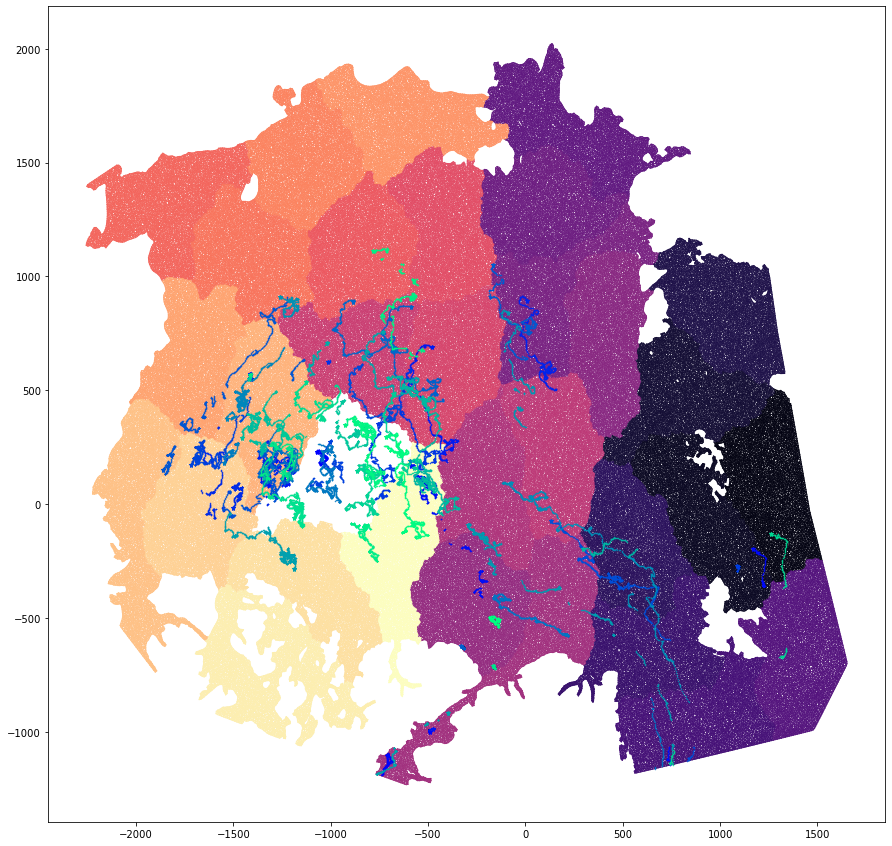

In [13]:
# create a color_list of NP different colors
cmap = cm.get_cmap('magma', NP)
color_list = [matplotlib.colors.rgb2hex(cmap(i)[:3]) for i in range(cmap.N)]
cmap2 = cm.get_cmap('winter', 60)

# create figure
ax = plt.figure(figsize=(15, 15)).add_subplot(111)
fig = ax.figure

#ax.set_xlim(-2000,1000)
#ax.set_ylim(-1000,1000)

# loop on the NP partitions and plot the corresponding collection of patches with a given color
for ip in range(0,NP):
    ax.add_collection(preparecollection4plt(allpatchlists[ip],color_list[ip]))

i=0
for filename in list_drifters:
    f = np.load('/bettik/alberta/small-arctic-10km-iabp/experiments/run_330d_iabp/drifters/'+str(filename))
    X = f['arr_0']*1e-3
    Y = f['arr_1']*1e-3
    ax.plot(X[0],Y[0],'*',color=matplotlib.colors.rgb2hex(cmap2(i)[:3]),markersize=5)
    for x, y in zip(X, Y):
        ax.plot(x,y,'.',color=matplotlib.colors.rgb2hex(cmap2(i)[:3]),markersize=1)
    i+=1


In [14]:
def plot_reg(reg):
    X1,X2,Y1,Y2 = reg
    # create a color_list of NP different colors
    cmap = cm.get_cmap('magma', NP)
    color_list = [matplotlib.colors.rgb2hex(cmap(i)[:3]) for i in range(cmap.N)]
    cmap2 = cm.get_cmap('winter', 60)

    # create figure
    ax = plt.figure(figsize=(15, 15)).add_subplot(111)
    fig = ax.figure

    ax.set_xlim(X1,X2)
    ax.set_ylim(Y1,Y2)

    # loop on the NP partitions and plot the corresponding collection of patches with a given color
    for ip in range(0,NP):
        ax.add_collection(preparecollection4plt(allpatchlists[ip],color_list[ip]))

    i=0
    for filename in list_drifters:
        f = np.load('/bettik/alberta/small-arctic-10km-iabp/experiments/run_330d_iabp/drifters/'+str(filename))
        X = f['arr_0']*1e-3
        Y = f['arr_1']*1e-3
        ax.plot(X[0],Y[0],'*',color=matplotlib.colors.rgb2hex(cmap2(i)[:3]),markersize=5)
        for x, y in zip(X, Y):
            ax.plot(x,y,'.',color=matplotlib.colors.rgb2hex(cmap2(i)[:3]),markersize=1)
        i+=1


In [15]:
#list_reg = [[-1500,-100,-2000,-1500],]
ylimits = [-2000,-1000,0,1000,2000]
xlimits = [-2000,-1000,0,1000,2000]
list_reg=[]
for i in np.arange(len(xlimits)-1):
    for j in np.arange(len(ylimits)-1):
        reg = [ xlimits[i],xlimits[i+1],xlimits[j],xlimits[j+1] ]
        list_reg.append(reg)

In [16]:
print(list_reg)

[[-2000, -1000, -2000, -1000], [-2000, -1000, -1000, 0], [-2000, -1000, 0, 1000], [-2000, -1000, 1000, 2000], [-1000, 0, -2000, -1000], [-1000, 0, -1000, 0], [-1000, 0, 0, 1000], [-1000, 0, 1000, 2000], [0, 1000, -2000, -1000], [0, 1000, -1000, 0], [0, 1000, 0, 1000], [0, 1000, 1000, 2000], [1000, 2000, -2000, -1000], [1000, 2000, -1000, 0], [1000, 2000, 0, 1000], [1000, 2000, 1000, 2000]]


In [17]:
list_reg2 = [[-2000, -1000, -200, 1000], [-1000, 0, -1200, 0], [-1000, 0, 0, 1000],
             [0, 1000, -1200, -1000],  [0, 1000, 0, 1000], 
             [1000, 2000, -1000, 0]]